# Clustering Tuscaloosa, Montgomery, Brimingham  Restaurants in Alabama

## 1. Introduction

### 1.1 Background

This is the capstone project of IBM Data Science Professional Certificate. In this project, I will use the Foursquare location data to explore venues in three city  Tuscaloosa, Montgomery, Brimingham in Alabama, and use Zomato api to get all the restaurants in these three city, and then come up with a problem that I can use the Foursquare location data to solve.

### 1.2 Problem

I will explore these restaurants and try to answer the question: "Where is the appropirate restaurant to invest in these three city?".

### 1.3 Interest

Alabama, also known as the Yellowhammer State, the Cotton State, and the Heart of Dixie, is considered to be the thirtieth largest state by area. What the state has become today is a product of the economic hardship it suffered in the past. In terms of business development, Alabama has many reasons to be proud of. Alabama is a hub for medicine and automotive manufacturing, with recent successes ranging from Remington to Polaris. Companies such as Airbus, Hyundai, and Mercedes-Benz locating plants in the state demonstrate how pro-business Alabama can be for big companies. A new study reveals that Alabama is likewise an attractive destination for small business entrepreneurs and owners. So invest in a restaurant in this city is an attractive idea for anyone who want to invest.

## 2. Data

To solve the problem, i'll use the <b>Foursquare API</b> to explore venue surrounding each restaurants. Foursquare outlines these high-level venue categories with more sub-categories.

    Arts & Entertainment (4d4b7104d754a06370d81259)
    College & University (4d4b7105d754a06372d81259)
    Event (4d4b7105d754a06373d81259)
    Food (4d4b7105d754a06374d81259)
    Nightlife Spot (4d4b7105d754a06376d81259)
    Outdoors & Recreation (4d4b7105d754a06377d81259)
    Professional & Other Places (4d4b7105d754a06375d81259)
    Residence (4e67e38e036454776db1fb3a)
    Shop & Service (4d4b7105d754a06378d81259)
    Travel & Transport (4d4b7105d754a06379d81259)

We’ll be querying the number of venues in each category in a 1000m radius around each restaurants. This radius was chosen because 1000m is a reasonable walking distance.

In [1]:
import pandas as pd
import numpy as np
import folium
import json
import requests
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim 
import pprint
import matplotlib.pyplot as plt
import seaborn as sns

CLIENT_ID = "FFEFW3ZL0BZ4UXSVKSI0XSGC3FGI30HCTRQ5GPZLSJUR0GSI"
CLIENT_SECRET = "NO3YYEJ35KLKMMAAEWLKRQOCEV0VG35RK5ENJX4NKR4DZAOG"
VERSION = "20180604"
#key zomatto
key = "509c6a5ac1f97d60b55b4dc3da482107"

### Tuscaloosa restaurants

In [2]:
tuscaloosa_restaurants = pd.DataFrame()
tuscaloosa_coord = (33.2098,-87.5692)
pages = [0,20,40,60,80]
for page in pages:
    uris = "https://developers.zomato.com/api/v2.1/search?lat={}&lon={}&apikey={}&radius={}&start={}&count={}".format(tuscaloosa_coord[0],tuscaloosa_coord[1],key,10000,page,20)
    request_ = requests.get(uris).json()
    csv_ = json_normalize(request_['restaurants'])
    tuscaloosa_restaurants = tuscaloosa_restaurants.append(csv_)

Clean the dataframe

In [3]:
#Reset the index of the dataframe, becuase the dataframe is the result of the append method
tuscaloosa_restaurants.reset_index(inplace=True, drop=True)
#The feature that i'll use
feature = ['restaurant.name','restaurant.cuisines','restaurant.average_cost_for_two','restaurant.user_rating.aggregate_rating','restaurant.timings','restaurant.all_reviews_count',
           'restaurant.user_rating.votes','restaurant.location.latitude','restaurant.location.longitude']
#Only use the feature that i consider as more valuable
tuscaloosa_restaurants = tuscaloosa_restaurants[feature]
#Convert some of the features that supose to be fload
col_to_convert_to_float = ['restaurant.user_rating.aggregate_rating','restaurant.user_rating.votes', 'restaurant.location.latitude', 'restaurant.location.longitude']
for col in col_to_convert_to_float:
    tuscaloosa_restaurants[col] = tuscaloosa_restaurants[col].astype(float)
#make a coordinate column
tuscaloosa_restaurants['coordinate'] = [(i,j) for i, j in zip(tuscaloosa_restaurants['restaurant.location.latitude'], tuscaloosa_restaurants['restaurant.location.longitude'])]
    

In [4]:
tuscaloosa_restaurants.head()

,restaurant.name,restaurant.cuisines,restaurant.average_cost_for_two,restaurant.user_rating.aggregate_rating,restaurant.timings,restaurant.all_reviews_count,restaurant.user_rating.votes,restaurant.location.latitude,restaurant.location.longitude,coordinate
0,City Cafe,"Diner, Seafood, Southern",10,3.8,"(Sun, Sat), Breakfast, Lunch (Mon-Fri)",38,288.0,33.21810,-87.57830,"(33.2181, -87.5783)"
1,Swen Chinese Restaurant,Chinese,25,3.6,"11 AM to 10 PM (Mon, Tue, Wed, Thu, Sun), 11 A...",37,192.0,33.21082,-87.55275,"(33.21082, -87.55275)"
2,DePalma's Italian Cafe,Italian,40,3.8,"Closed (Mon),11 AM to 10 PM (Tue-Thu),11 AM to...",93,428.0,33.21040,-87.56710,"(33.2104, -87.5671)"
3,Cypress Inn,"American, Seafood, Steak",40,3.5,"11 AM to 9 PM (Mon-Thu), 11 AM to 10 PM (Fri-S...",60,303.0,33.22921,-87.52863,"(33.22921, -87.52863)"
4,Mugshots Grill & Bar,"American, Burger, Bar Food",10,3.6,"11 AM to 10 PM (Mon-Thu),11 AM to 11 PM (Fri-S...",74,295.0,33.20960,-87.56810,"(33.2096, -87.5681)"


### Montgomery restaurants

In [5]:
montgomery_restaurants = pd.DataFrame()
montgomery_coord = (32.3792, -86.3077)
pages = [0,20,40,60,80]
for page in pages:
    uris = "https://developers.zomato.com/api/v2.1/search?lat={}&lon={}&apikey={}&radius={}&start={}&count={}".format(montgomery_coord[0],montgomery_coord[1],key,10000,page,20)
    request_ = requests.get(uris).json()
    csv_ = json_normalize(request_['restaurants'])
    montgomery_restaurants = montgomery_restaurants.append(csv_)

Clean the data with the same prosedure as Tuscaloosa data

In [6]:
montgomery_restaurants.reset_index(inplace=True, drop=True)
feature = ['restaurant.name','restaurant.cuisines','restaurant.average_cost_for_two','restaurant.user_rating.aggregate_rating','restaurant.timings','restaurant.all_reviews_count',
           'restaurant.user_rating.votes','restaurant.location.latitude','restaurant.location.longitude']
montgomery_restaurants = montgomery_restaurants[feature]
col_to_convert_to_float = ['restaurant.user_rating.aggregate_rating','restaurant.user_rating.votes', 'restaurant.location.latitude', 'restaurant.location.longitude']
for col in col_to_convert_to_float:
    montgomery_restaurants[col] = montgomery_restaurants[col].astype(float)
montgomery_restaurants['coordinate'] = [(i,j) for i, j in zip(montgomery_restaurants['restaurant.location.latitude'], montgomery_restaurants['restaurant.location.longitude'])]

In [7]:
montgomery_restaurants.head()

,restaurant.name,restaurant.cuisines,restaurant.average_cost_for_two,restaurant.user_rating.aggregate_rating,restaurant.timings,restaurant.all_reviews_count,restaurant.user_rating.votes,restaurant.location.latitude,restaurant.location.longitude,coordinate
0,Sa Za,"Italian, Pizza",40,4.2,"11 AM to 2 PM, 5 PM to 10 PM (Mon-Thu), 11 AM ...",101,262.0,32.379390,-86.311010,"(32.37939, -86.31101)"
1,Sushi Cafe,"Japanese, Sushi",25,4.9,"11 AM to 2:30 PM, 5 PM to 9:30 PM (Mon-Fri),5 ...",45,139.0,32.355817,-86.264911,"(32.355817, -86.264911)"
2,Lek's Railroad Thai,"Asian, Sushi, Thai",25,4.5,"11 AM to 9 PM (Mon-Thu),11 AM to 10 PM (Fri-Sa...",51,230.0,32.380500,-86.314000,"(32.3805, -86.314)"
3,Wishbone Cafe,"Sandwich, Seafood, Cajun",25,4.5,"(Sun),Lunch, Dinner (Mon-Sat)",59,150.0,32.382271,-86.171836,"(32.382271, -86.171836)"
4,Dreamland BBQ Montgomery,"BBQ, Burger, Sandwich",25,4.4,"10 AM to 9 PM (Mon-Thu), 10 AM to 10 PM (Fri-S...",59,198.0,32.380860,-86.310830,"(32.38086, -86.31083)"


### Brimingham restaurants

In [8]:
brimingham_restaurants = pd.DataFrame()
pages = [0,20,40,60,80]
brimingham_coord = (33.5186,-86.8104)
for page in pages:
    uris = "https://developers.zomato.com/api/v2.1/search?lat={}&lon={}&apikey={}&radius={}&start={}&count={}".format(brimingham_coord[0],brimingham_coord[1],key,10000,page,20)
    request_ = requests.get(uris).json()
    csv_ = json_normalize(request_['restaurants'])
    brimingham_restaurants = brimingham_restaurants.append(csv_)

Clean the data

In [9]:
brimingham_restaurants.reset_index(inplace=True, drop=True)
feature = ['restaurant.name','restaurant.cuisines','restaurant.average_cost_for_two','restaurant.user_rating.aggregate_rating','restaurant.timings','restaurant.all_reviews_count',
           'restaurant.user_rating.votes','restaurant.location.latitude','restaurant.location.longitude']
brimingham_restaurants = brimingham_restaurants[feature]
col_to_convert_to_float = ['restaurant.user_rating.aggregate_rating','restaurant.user_rating.votes', 'restaurant.location.latitude', 'restaurant.location.longitude']
for col in col_to_convert_to_float:
    brimingham_restaurants[col] = brimingham_restaurants[col].astype(float)
brimingham_restaurants['coordinate'] = [(i,j) for i, j in zip(brimingham_restaurants['restaurant.location.latitude'], brimingham_restaurants['restaurant.location.longitude'])]

In [10]:
brimingham_restaurants.head()

,restaurant.name,restaurant.cuisines,restaurant.average_cost_for_two,restaurant.user_rating.aggregate_rating,restaurant.timings,restaurant.all_reviews_count,restaurant.user_rating.votes,restaurant.location.latitude,restaurant.location.longitude,coordinate
0,Bottega Restaurant and Cafe,"Italian, Cafe, Pizza, Mediterranean",40,4.9,"11 AM to 10 PM (Tue-Sat), Mon & Sun Closed",98,814.0,33.502341,-86.789783,"(33.502341, -86.789783)"
1,GianMarco's,"Italian, Mediterranean, Southern",40,4.9,"5 PM to 10 PM (Mon, Tue, Sat), 11 AM to 2 PM, ...",161,826.0,33.463387,-86.812239,"(33.463387, -86.812239)"
2,Surin West,"Asian, Sushi, Thai",25,4.6,"11 AM to 9:30 PM (Mon-Thu), 11 AM to 10:30 PM ...",137,840.0,33.500760,-86.795540,"(33.50076, -86.79554)"
3,SAW's BBQ,"BBQ, Sandwich",25,4.7,"11 AM to 8 PM (Mon-Sat), Sun Closed",175,740.0,33.473800,-86.808290,"(33.4738, -86.80829)"
4,"Joe's Italian Pizza, Pasta & Caffe","Desserts, Italian, Pizza",25,4.7,10:30 AM to 9 PM (Mon-Sun),314,739.0,33.259583,-86.796361,"(33.259583, -86.796361)"


Get the venues for each city using Foursquare API

In [11]:
#The list category of venues
venue_cat = ['Arts_Entertainment', 'College_University', 'Event', 'Nightlife_Spot', 'Outdoors_Recreation',
            'Professional_n_Other_Places', 'Shop_Service', 'Travel_Transport', 'Residence']
#The Id for each venue category
venue_cat_id = ['4d4b7104d754a06370d81259','4d4b7105d754a06372d81259','4d4b7105d754a06373d81259', '4d4b7105d754a06376d81259','4d4b7105d754a06377d81259','4d4b7105d754a06375d81259','4d4b7105d754a06378d81259','4d4b7105d754a06379d81259', '4e67e38e036454776db1fb3a']


ra = []

#three towns coordinates (tusaloosa, montgomary, brimingham)
coord = [(33.2098,-87.5692), (32.3792, -86.3077), (33.5186, -86.8104)]

#get the venue for each category and for each city, with radius 20000m
for (i,j) in coord:
    reqs1 = []
    for cat, cat_id in zip(venue_cat,venue_cat_id):
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            i, 
            j, 
            20000,
            cat_id)
            results = requests.get(url).json()
            reqs1.append(results)
    ra.append(reqs1)


Group the venues for each city

In [12]:
ra[0][3]

{'meta': {'code': 200, 'requestId': '5dc11679f96b2c0039738692'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'},
    {'name': '$-$$$$', 'key': 'price'}]},
  'headerLocation': 'Tuscaloosa',
  'headerFullLocation': 'Tuscaloosa',
  'headerLocationGranularity': 'city',
  'query': 'nightlife',
  'totalResults': 35,
  'suggestedBounds': {'ne': {'lat': 33.38980018000018,
    'lng': -87.35446305399667},
   'sw': {'lat': 33.02979981999982, 'lng': -87.78393694600332}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '52da0363498ee92698ffd8ad',
       'name': 'The Avenue Pub',
       'location': {'address': '405 23rd Ave',
        'lat': 33.21098692413535,
        'lng': -87.56698565086404,
        'labeledLatLngs':

In [13]:
#convert the address from a list to a string
def concat(x):
    s = x[0]
    for st in x[1:]:
        s += ', '+st
    return s

def city_venues(venue_cat, result_respond):
    result = {}
    for venue, json in zip(venue_cat, result_respond):
        feature = ['categories', 'id', 'location.formattedAddress', 'location.lat', 'location.lng', 'name']
        data1 = pd.DataFrame(columns = feature)
        for rest in json['response']['groups'][0]['items']:
                d = json_normalize(rest['venue'])
                d = d[feature]
                d['categories'] = [data[0]['name'] for data in d['categories']]
                d['location.formattedAddress'] = d['location.formattedAddress'].apply(concat)
                data1 = data1.append(d)
        data1.reset_index(inplace=True, drop = True)
        data1['coordinate'] = [(i,j) for i,j in zip(data1['location.lat'], data1['location.lng'])]
        result[venue] = data1
    return result

Tuscaloosa_venues = city_venues(venue_cat, ra[0])
Montgomery_venues = city_venues(venue_cat, ra[1])
Brimingham_venues = city_venues(venue_cat, ra[2])

In [14]:
Tuscaloosa_venues

{'Arts_Entertainment':                categories                        id  \
 0            Concert Hall  4d431b8785c1721e4ed5e592   
 1   Performing Arts Venue  4f47f599e4b08df2fb086199   
 2          History Museum  4bd0696341b9ef3be1faf9e5   
 3   Performing Arts Venue  4b808bc2f964a520bf7b30e3   
 4               Multiplex  4b78a2adf964a52045db2ee3   
 5             Art Gallery  4bca0830511f95216fd6aec7   
 6                 Theater  4bbc0c7fe4529521058f55a4   
 7          History Museum  4d66a25b84f28cfa1ed06d69   
 8                  Museum  4b639600f964a5201b852ae3   
 9             Art Gallery  537e928d498e0a200b4dd747   
 10                 Museum  53304f07498e73153e0434ce   
 11         History Museum  52c9a60211d21fde706697cb   
 12         History Museum  4bf73e105317a5936fd0fd7e   
 13           Dance Studio  586dfc24b2101471980f3c34   
 14      Outdoor Sculpture  4f95db53e4b058034bd10852   
 15            Music Venue  4ea1c8114fc6db90f2711e7a   
 16                Theater

In [15]:
Montgomery_venues

{'Arts_Entertainment':                categories                        id  \
 0          History Museum  4b9fa9f4f964a520e03237e3   
 1          History Museum  4b9f97d5f964a520962d37e3   
 2          History Museum  5ae485366e4650002cef1a4f   
 3             Music Venue  4b6fc2c6f964a520cafb2ce3   
 4                 Theater  4da460a7540ea1cdd4e3a3de   
 5                 Theater  4e92fe9b93adf0b0008f2d67   
 6          History Museum  4c053618f56c2d7fad4b1f66   
 7           Movie Theater  4b6fbb38f964a52018fb2ce3   
 8              Art Museum  4c48ca3a1b430f47d9b3a8c2   
 9          History Museum  5241f34a11d2c7333396493c   
 10            Music Venue  4c52cd86048b1b8d4474ef30   
 11         History Museum  4d0fd39be2365481960a74ea   
 12          Movie Theater  4b5226e0f964a520c86b27e3   
 13          Movie Theater  53aa3b3e11d2c3fee0ea0b7f   
 14                 Museum  4b8632f0f964a520778231e3   
 15         Science Museum  4d86a70e353060fcd6db12e3   
 16            Planetarium

In [16]:
Brimingham_venues

{'Arts_Entertainment':              categories                        id  \
 0        Science Museum  4b4f5b65f964a520e80227e3   
 1            Art Museum  4c408a2ada3dc928e178c7b9   
 2        History Museum  4b44af02f964a52066f925e3   
 3               Theater  4b79a243f964a52019072fe3   
 4               Theater  4c9cd3ca7c096dcbf428c5d1   
 5           Music Venue  50b54fede4b075ec624ea157   
 6          Concert Hall  4b99b115f964a520508c35e3   
 7             Rock Club  4b34cfcbf964a520a92825e3   
 8          Concert Hall  4b5a533ff964a52056bd28e3   
 9             Rock Club  54b9bcef498e9ede49afff72   
 10          Music Venue  4b60b458f964a520eef429e3   
 11              Theater  4f77a09ce4b05c37fbae8869   
 12          Art Gallery  4b071dd1f964a52091f722e3   
 13              Theater  4bccd6550687ef3b26ffdfcc   
 14               Museum  4fda890c6b74a5d045dd522f   
 15              Theater  4bb3dd3435f0c9b6c500bd83   
 16        Movie Theater  596146057269fe39b86ed2c9   
 17  I

 Measure the distance for every restaurant to every venues for each city

First we difne the Haversine function to measure the distance between two coordinates

In [17]:
import math

def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

Then i'll measure the distance for every coordinate restaurant to each city venue from the result above then get the number of each venue category that still inside the 1000m radius and return in it as a list

In [18]:
def distance(coord, city_venues):
    a = []
    for cat, dataframe in city_venues.items():
            nearest_distance = [haversine(coord, i) for i in dataframe['coordinate']]
            a.append(nearest_distance)
    for i in a:
        i = np.array(i)
    a = pd.DataFrame(a).transpose()
    a = list(a[a<=1000].notnull().sum())
    return a

Using that function, i'll append the result to each city restaurant dataframe

In [19]:
lists1 = np.array([distance(coord, Tuscaloosa_venues) for coord in tuscaloosa_restaurants['coordinate']])
new_dataframe1 = pd.DataFrame(lists1, columns = venue_cat)
tuscaloosa_restaurants = pd.concat([tuscaloosa_restaurants, new_dataframe1], axis = 1)

lists2 = np.array([distance(coord, Montgomery_venues) for coord in montgomery_restaurants['coordinate']])
new_dataframe2 = pd.DataFrame(lists2, columns = venue_cat)
montgomery_restaurants = pd.concat([montgomery_restaurants, new_dataframe2], axis = 1)

lists3 = np.array([distance(coord, Brimingham_venues) for coord in brimingham_restaurants['coordinate']])
new_dataframe3 = pd.DataFrame(lists3, columns = venue_cat)
brimingham_restaurants = pd.concat([brimingham_restaurants, new_dataframe3], axis = 1)

In [20]:
tuscaloosa_restaurants.head()

,restaurant.name,restaurant.cuisines,restaurant.average_cost_for_two,restaurant.user_rating.aggregate_rating,restaurant.timings,restaurant.all_reviews_count,restaurant.user_rating.votes,restaurant.location.latitude,restaurant.location.longitude,coordinate,Arts_Entertainment,College_University,Event,Nightlife_Spot,Outdoors_Recreation,Professional_n_Other_Places,Shop_Service,Travel_Transport,Residence
0,City Cafe,"Diner, Seafood, Southern",10,3.8,"(Sun, Sat), Breakfast, Lunch (Mon-Fri)",38,288.0,33.21810,-87.57830,"(33.2181, -87.5783)",4,0,1,1,0,1,0,2,0
1,Swen Chinese Restaurant,Chinese,25,3.6,"11 AM to 10 PM (Mon, Tue, Wed, Thu, Sun), 11 A...",37,192.0,33.21082,-87.55275,"(33.21082, -87.55275)",6,23,1,9,4,4,4,0,1
2,DePalma's Italian Cafe,Italian,40,3.8,"Closed (Mon),11 AM to 10 PM (Tue-Thu),11 AM to...",93,428.0,33.21040,-87.56710,"(33.2104, -87.5671)",11,0,2,17,3,6,2,7,1
3,Cypress Inn,"American, Seafood, Steak",40,3.5,"11 AM to 9 PM (Mon-Thu), 11 AM to 10 PM (Fri-S...",60,303.0,33.22921,-87.52863,"(33.22921, -87.52863)",0,0,0,0,0,2,0,0,1
4,Mugshots Grill & Bar,"American, Burger, Bar Food",10,3.6,"11 AM to 10 PM (Mon-Thu),11 AM to 11 PM (Fri-S...",74,295.0,33.20960,-87.56810,"(33.2096, -87.5681)",11,0,2,17,3,6,2,7,1


In [21]:
montgomery_restaurants.head()

,restaurant.name,restaurant.cuisines,restaurant.average_cost_for_two,restaurant.user_rating.aggregate_rating,restaurant.timings,restaurant.all_reviews_count,restaurant.user_rating.votes,restaurant.location.latitude,restaurant.location.longitude,coordinate,Arts_Entertainment,College_University,Event,Nightlife_Spot,Outdoors_Recreation,Professional_n_Other_Places,Shop_Service,Travel_Transport,Residence
0,Sa Za,"Italian, Pizza",40,4.2,"11 AM to 2 PM, 5 PM to 10 PM (Mon-Thu), 11 AM ...",101,262.0,32.379390,-86.311010,"(32.37939, -86.31101)",12,3,0,7,1,4,0,4,1
1,Sushi Cafe,"Japanese, Sushi",25,4.9,"11 AM to 2:30 PM, 5 PM to 9:30 PM (Mon-Fri),5 ...",45,139.0,32.355817,-86.264911,"(32.355817, -86.264911)",0,0,0,1,1,1,2,0,0
2,Lek's Railroad Thai,"Asian, Sushi, Thai",25,4.5,"11 AM to 9 PM (Mon-Thu),11 AM to 10 PM (Fri-Sa...",51,230.0,32.380500,-86.314000,"(32.3805, -86.314)",10,2,0,7,2,4,0,4,1
3,Wishbone Cafe,"Sandwich, Seafood, Cajun",25,4.5,"(Sun),Lunch, Dinner (Mon-Sat)",59,150.0,32.382271,-86.171836,"(32.382271, -86.171836)",0,0,0,0,0,0,1,0,0
4,Dreamland BBQ Montgomery,"BBQ, Burger, Sandwich",25,4.4,"10 AM to 9 PM (Mon-Thu), 10 AM to 10 PM (Fri-S...",59,198.0,32.380860,-86.310830,"(32.38086, -86.31083)",11,2,0,7,1,4,0,4,1


In [22]:
brimingham_restaurants.head()

,restaurant.name,restaurant.cuisines,restaurant.average_cost_for_two,restaurant.user_rating.aggregate_rating,restaurant.timings,restaurant.all_reviews_count,restaurant.user_rating.votes,restaurant.location.latitude,restaurant.location.longitude,coordinate,Arts_Entertainment,College_University,Event,Nightlife_Spot,Outdoors_Recreation,Professional_n_Other_Places,Shop_Service,Travel_Transport,Residence
0,Bottega Restaurant and Cafe,"Italian, Cafe, Pizza, Mediterranean",40,4.9,"11 AM to 10 PM (Tue-Sat), Mon & Sun Closed",98,814.0,33.502341,-86.789783,"(33.502341, -86.789783)",2,1,0,7,3,2,1,2,4
1,GianMarco's,"Italian, Mediterranean, Southern",40,4.9,"5 PM to 10 PM (Mon, Tue, Sat), 11 AM to 2 PM, ...",161,826.0,33.463387,-86.812239,"(33.463387, -86.812239)",0,0,0,0,1,0,2,0,1
2,Surin West,"Asian, Sushi, Thai",25,4.6,"11 AM to 9:30 PM (Mon-Thu), 11 AM to 10:30 PM ...",137,840.0,33.500760,-86.795540,"(33.50076, -86.79554)",3,7,0,7,3,2,1,2,5
3,SAW's BBQ,"BBQ, Sandwich",25,4.7,"11 AM to 8 PM (Mon-Sat), Sun Closed",175,740.0,33.473800,-86.808290,"(33.4738, -86.80829)",0,0,0,1,0,0,0,0,1
4,"Joe's Italian Pizza, Pasta & Caffe","Desserts, Italian, Pizza",25,4.7,10:30 AM to 9 PM (Mon-Sun),314,739.0,33.259583,-86.796361,"(33.259583, -86.796361)",0,0,0,0,0,0,0,0,0


After I got the number of for each category venue for each restaurant, for each city. I'll merge the three city restaurant dataframe

In [23]:
restaurants = pd.concat([tuscaloosa_restaurants, montgomery_restaurants, brimingham_restaurants], axis = 0).reset_index(drop=True)

In [24]:
restaurants

,restaurant.name,restaurant.cuisines,restaurant.average_cost_for_two,restaurant.user_rating.aggregate_rating,restaurant.timings,restaurant.all_reviews_count,restaurant.user_rating.votes,restaurant.location.latitude,restaurant.location.longitude,coordinate,Arts_Entertainment,College_University,Event,Nightlife_Spot,Outdoors_Recreation,Professional_n_Other_Places,Shop_Service,Travel_Transport,Residence
0,City Cafe,"Diner, Seafood, Southern",10,3.8,"(Sun, Sat), Breakfast, Lunch (Mon-Fri)",38,288.0,33.218100,-87.578300,"(33.2181, -87.5783)",4,0,1,1,0,1,0,2,0
1,Swen Chinese Restaurant,Chinese,25,3.6,"11 AM to 10 PM (Mon, Tue, Wed, Thu, Sun), 11 A...",37,192.0,33.210820,-87.552750,"(33.21082, -87.55275)",6,23,1,9,4,4,4,0,1
2,DePalma's Italian Cafe,Italian,40,3.8,"Closed (Mon),11 AM to 10 PM (Tue-Thu),11 AM to...",93,428.0,33.210400,-87.567100,"(33.2104, -87.5671)",11,0,2,17,3,6,2,7,1
3,Cypress Inn,"American, Seafood, Steak",40,3.5,"11 AM to 9 PM (Mon-Thu), 11 AM to 10 PM (Fri-S...",60,303.0,33.229210,-87.528630,"(33.22921, -87.52863)",0,0,0,0,0,2,0,0,1
4,Mugshots Grill & Bar,"American, Burger, Bar Food",10,3.6,"11 AM to 10 PM (Mon-Thu),11 AM to 11 PM (Fri-S...",74,295.0,33.209600,-87.568100,"(33.2096, -87.5681)",11,0,2,17,3,6,2,7,1
5,Hooligan's American,"American, Mediterranean",10,3.6,"Lunch, Dinner (Sun, Mon, Tue, Wed, Thu, Fri, Sat)",39,246.0,33.211500,-87.561800,"(33.2115, -87.5618)",9,0,2,24,3,5,4,7,1
6,Dreamland BBQ Tuscaloosa,"BBQ, Desserts",25,3.5,"10 AM to 9 PM (Mon-Sat), 11 AM to 9 PM (Sun)",62,266.0,33.157370,-87.516760,"(33.15737, -87.51676)",0,0,0,0,0,0,0,0,0
7,Chuck's Fish,"American, Seafood, Sushi",40,3.5,"5 PM to 10 PM (Mon-Thu),5 PM to 11 PM (Fri-Sat...",47,242.0,33.209613,-87.568381,"(33.209613, -87.568381)",11,0,2,17,3,6,2,7,1
8,Waysider,"American, Breakfast, Southern",10,3.6,"Closed (Mon),5:30 AM to 2 PM (Tue-Fri),5:30 AM...",39,236.0,33.199600,-87.564300,"(33.1996, -87.5643)",3,0,1,2,2,3,0,1,1
9,Nick's in the Sticks,Steak,25,3.7,"5 PM to 9 PM (Mon-Thu),5 PM to 10 PM (Fri-Sat)...",38,207.0,33.177203,-87.614321,"(33.177203, -87.614321)",0,0,0,0,0,0,0,0,0


In [48]:
restaurants.to_csv("restaurants.csv")

## 3. Methodology

### 3.1 Explore Dataset

### Visualize the Restaurants  venue

In [25]:
loc = [33.5186, -86.8104]
map_ = folium.Map(loc, zoom_start = 11)

for lat, lon, poi in zip(restaurants['restaurant.location.latitude'], restaurants['restaurant.location.longitude'], restaurants['restaurant.name']):
    label = folium.Popup(poi, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color= 'blue',
        fill_opacity=0.7).add_to(map_)

map_

### 3.2 Pre-processing Data

In [26]:
X = restaurants.drop(['restaurant.name', 'restaurant.cuisines', 'restaurant.timings', 'coordinate','restaurant.location.latitude','restaurant.location.longitude'],axis = 1)
X.head()

,restaurant.average_cost_for_two,restaurant.user_rating.aggregate_rating,restaurant.all_reviews_count,restaurant.user_rating.votes,Arts_Entertainment,College_University,Event,Nightlife_Spot,Outdoors_Recreation,Professional_n_Other_Places,Shop_Service,Travel_Transport,Residence
0,10,3.8,38,288.0,4,0,1,1,0,1,0,2,0
1,25,3.6,37,192.0,6,23,1,9,4,4,4,0,1
2,40,3.8,93,428.0,11,0,2,17,3,6,2,7,1
3,40,3.5,60,303.0,0,0,0,0,0,2,0,0,1
4,10,3.6,74,295.0,11,0,2,17,3,6,2,7,1


In [27]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X

array([[-0.87596737, -0.23189218, -0.1432726 , ..., -0.54664725,
         0.29243116, -0.73186535],
       [ 0.13606168, -0.71500088, -0.16758356, ...,  0.6525789 ,
        -0.66635953, -0.01199779],
       [ 1.14809073, -0.23189218,  1.19383029, ...,  0.05296582,
         2.68940789, -0.01199779],
       ...,
       [-0.87596737,  0.00966217,  1.48556182, ..., -0.54664725,
        -0.66635953, -0.73186535],
       [ 0.81074772,  0.49277087,  1.29107413, ...,  0.35277236,
        -0.66635953, -0.73186535],
       [ 0.13606168,  0.00966217,  1.14520836, ..., -0.54664725,
        -0.66635953, -0.73186535]])

### 3.3 Clustering

I'm going to cluster the restaurants using K-Means Clustering

In [28]:
from sklearn.cluster import KMeans
clusterNumber = 6
k_means = KMeans(init = "k-means++", n_clusters = clusterNumber, n_init = 12, random_state=3425)
k_means.fit(X)
class_label = k_means.labels_
restaurants['class'] = class_label

## 4. Results

### 4.1 Visualize Clusters

In [29]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(loc, zoom_start = 10)

# set color scheme for the clusters
x = np.arange(clusterNumber)
ys = [i + x + (i*x)**2 for i in range(clusterNumber)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
labels = restaurants['restaurant.name']

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(restaurants['restaurant.location.latitude'], restaurants['restaurant.location.longitude'], labels, restaurants['class']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)

       
map_clusters

### 4.2 Explore each Clusters

In [30]:
restaurants[restaurants['class'] == 0].describe()

,restaurant.average_cost_for_two,restaurant.user_rating.aggregate_rating,restaurant.all_reviews_count,restaurant.user_rating.votes,restaurant.location.latitude,restaurant.location.longitude,Arts_Entertainment,College_University,Event,Nightlife_Spot,Outdoors_Recreation,Professional_n_Other_Places,Shop_Service,Travel_Transport,Residence,class
count,20.000000,20.000000,20.00000,20.00000,20.000000,20.000000,20.00000,20.0,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.0
mean,25.500000,3.455000,29.10000,117.55000,33.211154,-87.567165,10.25000,0.0,1.900000,17.950000,2.800000,5.750000,2.35000,6.800000,0.950000,0.0
std,17.836981,0.135627,22.24481,108.35394,0.001864,0.002955,0.71635,0.0,0.307794,2.605157,0.615587,1.118034,0.67082,0.410391,0.510418,0.0
min,10.000000,3.300000,9.00000,15.00000,33.209271,-87.573860,9.00000,0.0,1.000000,14.000000,1.000000,3.000000,2.00000,6.000000,0.000000,0.0
25%,10.000000,3.375000,13.00000,53.50000,33.209663,-87.568373,10.00000,0.0,2.000000,17.000000,3.000000,5.750000,2.00000,7.000000,1.000000,0.0
50%,25.000000,3.400000,21.00000,68.50000,33.210878,-87.567144,10.00000,0.0,2.000000,17.000000,3.000000,6.000000,2.00000,7.000000,1.000000,0.0
75%,40.000000,3.525000,33.00000,140.00000,33.211492,-87.565860,11.00000,0.0,2.000000,17.500000,3.000000,6.000000,2.25000,7.000000,1.000000,0.0
max,70.000000,3.800000,93.00000,428.00000,33.216000,-87.561800,11.00000,0.0,2.000000,24.000000,3.000000,7.000000,4.00000,7.000000,2.000000,0.0


In [31]:
restaurants[restaurants['class'] == 1].describe()

,restaurant.average_cost_for_two,restaurant.user_rating.aggregate_rating,restaurant.all_reviews_count,restaurant.user_rating.votes,restaurant.location.latitude,restaurant.location.longitude,Arts_Entertainment,College_University,Event,Nightlife_Spot,Outdoors_Recreation,Professional_n_Other_Places,Shop_Service,Travel_Transport,Residence,class
count,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.000000,89.0
mean,31.067416,4.241573,84.146067,328.213483,33.297200,-86.714855,0.528090,0.134831,0.235955,0.786517,0.606742,0.471910,1.146067,0.404494,0.775281,1.0
std,16.051620,0.274611,45.676120,169.450950,0.376783,0.227846,1.045443,0.786115,0.427000,1.786769,0.984170,0.658681,1.563436,0.669449,1.371403,0.0
min,10.000000,3.500000,17.000000,72.000000,32.319198,-87.528630,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,25.000000,4.100000,59.000000,205.000000,33.375051,-86.800347,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,25.000000,4.200000,78.000000,273.000000,33.446592,-86.773851,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,40.000000,4.400000,98.000000,444.000000,33.479771,-86.712513,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.0
max,70.000000,4.900000,314.000000,826.000000,33.644580,-86.171836,5.000000,7.000000,1.000000,8.000000,4.000000,3.000000,5.000000,4.000000,5.000000,1.0


In [32]:
restaurants[restaurants['class'] == 2].describe()

,restaurant.average_cost_for_two,restaurant.user_rating.aggregate_rating,restaurant.all_reviews_count,restaurant.user_rating.votes,restaurant.location.latitude,restaurant.location.longitude,Arts_Entertainment,College_University,Event,Nightlife_Spot,Outdoors_Recreation,Professional_n_Other_Places,Shop_Service,Travel_Transport,Residence,class
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.0,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.0
mean,18.333333,3.420000,12.933333,76.800000,33.193825,-87.527427,0.400000,0.933333,0.0,1.133333,2.733333,2.200000,15.00000,0.333333,2.466667,2.0
std,12.344268,0.108233,12.383553,51.035282,0.003198,0.002336,0.507093,0.258199,0.0,0.351866,0.457738,0.861892,2.13809,0.487950,1.125463,0.0
min,10.000000,3.200000,2.000000,31.000000,33.188300,-87.535174,0.000000,0.000000,0.0,1.000000,2.000000,1.000000,10.00000,0.000000,1.000000,2.0
25%,10.000000,3.400000,5.500000,49.500000,33.191680,-87.527830,0.000000,1.000000,0.0,1.000000,2.500000,1.500000,13.50000,0.000000,1.500000,2.0
50%,10.000000,3.400000,8.000000,61.000000,33.194220,-87.526370,0.000000,1.000000,0.0,1.000000,3.000000,2.000000,16.00000,0.000000,3.000000,2.0
75%,25.000000,3.450000,13.500000,81.000000,33.196806,-87.526242,1.000000,1.000000,0.0,1.000000,3.000000,3.000000,16.50000,1.000000,3.000000,2.0
max,40.000000,3.700000,43.000000,234.000000,33.197688,-87.525690,1.000000,1.000000,0.0,2.000000,3.000000,3.000000,17.00000,1.000000,4.000000,2.0


In [33]:
restaurants[restaurants['class'] == 3].describe()

,restaurant.average_cost_for_two,restaurant.user_rating.aggregate_rating,restaurant.all_reviews_count,restaurant.user_rating.votes,restaurant.location.latitude,restaurant.location.longitude,Arts_Entertainment,College_University,Event,Nightlife_Spot,Outdoors_Recreation,Professional_n_Other_Places,Shop_Service,Travel_Transport,Residence,class
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0
mean,24.250000,4.045000,55.950000,325.550000,33.384457,-87.101070,4.100000,15.600000,0.400000,7.750000,3.200000,2.300000,2.100000,1.700000,2.650000,3.0
std,17.864622,0.475145,33.562942,231.117759,0.145821,0.379267,2.221901,6.394076,0.502625,2.899637,1.056309,1.301821,1.410487,1.625455,1.565248,0.0
min,10.000000,3.400000,7.000000,44.000000,33.206500,-87.555900,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.0
25%,10.000000,3.600000,35.750000,172.750000,33.211117,-87.552787,2.000000,9.750000,0.000000,6.000000,3.000000,1.000000,1.000000,0.000000,1.000000,3.0
50%,25.000000,4.200000,50.500000,239.500000,33.497238,-86.802641,4.000000,15.500000,0.000000,7.500000,3.500000,2.500000,2.000000,2.000000,3.000000,3.0
75%,25.000000,4.400000,69.750000,443.000000,33.500539,-86.796853,6.000000,22.250000,1.000000,9.000000,4.000000,3.000000,3.250000,2.000000,4.000000,3.0
max,70.000000,4.800000,137.000000,840.000000,33.508044,-86.795540,8.000000,24.000000,1.000000,13.000000,4.000000,4.000000,4.000000,5.000000,5.000000,3.0


In [34]:
restaurants[restaurants['class'] == 4].describe()

,restaurant.average_cost_for_two,restaurant.user_rating.aggregate_rating,restaurant.all_reviews_count,restaurant.user_rating.votes,restaurant.location.latitude,restaurant.location.longitude,Arts_Entertainment,College_University,Event,Nightlife_Spot,Outdoors_Recreation,Professional_n_Other_Places,Shop_Service,Travel_Transport,Residence,class
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.0
mean,17.299270,3.727007,19.583942,75.773723,32.771065,-86.798445,0.635036,0.430657,0.065693,0.649635,0.554745,0.832117,0.912409,0.875912,0.693431,4.0
std,9.926469,0.324831,10.859153,52.740206,0.432134,0.625732,0.991700,1.413151,0.248655,1.081878,0.930842,1.121772,1.203393,1.184739,1.222113,0.0
min,0.000000,2.900000,2.000000,17.000000,32.265915,-87.614321,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0
25%,10.000000,3.400000,11.000000,41.000000,32.360069,-87.538137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0
50%,10.000000,3.700000,17.000000,54.000000,32.461798,-86.419600,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.0
75%,25.000000,4.000000,24.000000,86.000000,33.218100,-86.214792,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.0
max,40.000000,4.600000,62.000000,288.000000,33.502230,-86.125364,4.000000,8.000000,1.000000,5.000000,5.000000,5.000000,5.000000,6.000000,4.000000,4.0


In [35]:
restaurants[restaurants['class'] == 5].describe()

,restaurant.average_cost_for_two,restaurant.user_rating.aggregate_rating,restaurant.all_reviews_count,restaurant.user_rating.votes,restaurant.location.latitude,restaurant.location.longitude,Arts_Entertainment,College_University,Event,Nightlife_Spot,Outdoors_Recreation,Professional_n_Other_Places,Shop_Service,Travel_Transport,Residence,class
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.0
mean,25.789474,4.178947,57.947368,202.684211,32.737820,-86.464565,12.473684,2.105263,0.105263,7.526316,2.421053,5.473684,0.315789,4.526316,1.684211,5.0
std,16.181536,0.318990,36.841211,147.104669,0.543992,0.238016,2.457831,1.100239,0.315302,3.501879,2.116491,1.263523,0.582393,2.412201,1.249561,0.0
min,10.000000,3.600000,11.000000,37.000000,32.371133,-86.809383,9.000000,0.000000,0.000000,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,5.0
25%,10.000000,4.050000,28.000000,88.000000,32.377171,-86.802482,10.500000,1.000000,0.000000,7.000000,1.000000,4.000000,0.000000,4.000000,1.000000,5.0
50%,25.000000,4.200000,51.000000,198.000000,32.380500,-86.310820,12.000000,2.000000,0.000000,7.000000,1.000000,6.000000,0.000000,4.000000,1.000000,5.0
75%,40.000000,4.400000,79.000000,249.000000,33.515105,-86.305999,14.500000,3.000000,0.000000,10.000000,4.000000,6.000000,0.500000,6.500000,2.500000,5.0
max,70.000000,4.700000,151.000000,595.000000,33.522703,-86.299491,16.000000,4.000000,1.000000,13.000000,6.000000,8.000000,2.000000,8.000000,4.000000,5.0


By looking at the stats descrption, in the cluster 1 the restaurants seems more expensive than the other clusters, and the number of rating votes is higher than the other clusters and also the rating is really high.

But if we looking for the good location strategy for restaurant to invest, we can consider cluster 0,just by looking at the stat desc, we can see that cluster 0 have more variety of venues around their restaurants. 

In [36]:
restaurants[restaurants['class'] == 0].head()

,restaurant.name,restaurant.cuisines,restaurant.average_cost_for_two,restaurant.user_rating.aggregate_rating,restaurant.timings,restaurant.all_reviews_count,restaurant.user_rating.votes,restaurant.location.latitude,restaurant.location.longitude,coordinate,Arts_Entertainment,College_University,Event,Nightlife_Spot,Outdoors_Recreation,Professional_n_Other_Places,Shop_Service,Travel_Transport,Residence,class
2,DePalma's Italian Cafe,Italian,40,3.8,"Closed (Mon),11 AM to 10 PM (Tue-Thu),11 AM to...",93,428.0,33.210400,-87.567100,"(33.2104, -87.5671)",11,0,2,17,3,6,2,7,1,0
4,Mugshots Grill & Bar,"American, Burger, Bar Food",10,3.6,"11 AM to 10 PM (Mon-Thu),11 AM to 11 PM (Fri-S...",74,295.0,33.209600,-87.568100,"(33.2096, -87.5681)",11,0,2,17,3,6,2,7,1,0
5,Hooligan's American,"American, Mediterranean",10,3.6,"Lunch, Dinner (Sun, Mon, Tue, Wed, Thu, Fri, Sat)",39,246.0,33.211500,-87.561800,"(33.2115, -87.5618)",9,0,2,24,3,5,4,7,1,0
7,Chuck's Fish,"American, Seafood, Sushi",40,3.5,"5 PM to 10 PM (Mon-Thu),5 PM to 11 PM (Fri-Sat...",47,242.0,33.209613,-87.568381,"(33.209613, -87.568381)",11,0,2,17,3,6,2,7,1,0
12,Five Bar Tuscaloosa,Coffee and Tea,40,3.6,"5 PM to 10 PM (Mon-Thu),11 AM to 12 Midnight (...",50,200.0,33.209271,-87.566952,"(33.209271, -87.566952)",11,0,2,17,3,6,2,6,1,0


In [37]:
restaurants[restaurants['class'] == 1].head()

,restaurant.name,restaurant.cuisines,restaurant.average_cost_for_two,restaurant.user_rating.aggregate_rating,restaurant.timings,restaurant.all_reviews_count,restaurant.user_rating.votes,restaurant.location.latitude,restaurant.location.longitude,coordinate,Arts_Entertainment,College_University,Event,Nightlife_Spot,Outdoors_Recreation,Professional_n_Other_Places,Shop_Service,Travel_Transport,Residence,class
3,Cypress Inn,"American, Seafood, Steak",40,3.5,"11 AM to 9 PM (Mon-Thu), 11 AM to 10 PM (Fri-S...",60,303.0,33.229210,-87.528630,"(33.22921, -87.52863)",0,0,0,0,0,2,0,0,1,1
11,Baumhower's Restaurant,"American, Burger, Steak",25,3.5,"9:50 AM a 10:10 AM (Seg),10 AM a 8 PM (Ter-Dom)",106,214.0,33.212937,-87.523579,"(33.212937, -87.523579)",0,2,0,1,2,2,0,1,5,1
101,Sushi Cafe,"Japanese, Sushi",25,4.9,"11 AM to 2:30 PM, 5 PM to 9:30 PM (Mon-Fri),5 ...",45,139.0,32.355817,-86.264911,"(32.355817, -86.264911)",0,0,0,1,1,1,2,0,0,1
103,Wishbone Cafe,"Sandwich, Seafood, Cajun",25,4.5,"(Sun),Lunch, Dinner (Mon-Sat)",59,150.0,32.382271,-86.171836,"(32.382271, -86.171836)",0,0,0,0,0,0,1,0,0,1
105,Tomatinos Pizza & Bake Shop,"Pizza, Vegetarian",25,4.4,"Dinner (Sun),Lunch, Dinner (Mon-Sat)",56,227.0,32.351900,-86.291500,"(32.3519, -86.2915)",4,7,0,5,0,0,0,0,0,1


In [38]:
cluster_0 = restaurants[restaurants['class'] == 0]
cluster_1 = restaurants[restaurants['class'] == 1]
cluster_2 = restaurants[restaurants['class'] == 2]
cluster_3 = restaurants[restaurants['class'] == 3]
cluster_4 = restaurants[restaurants['class'] == 4]
cluster_5 = restaurants[restaurants['class'] == 5]
clusters = [cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5]

We can use Heatmap to visualize the number of venue for each category for each restuarants in every cluster

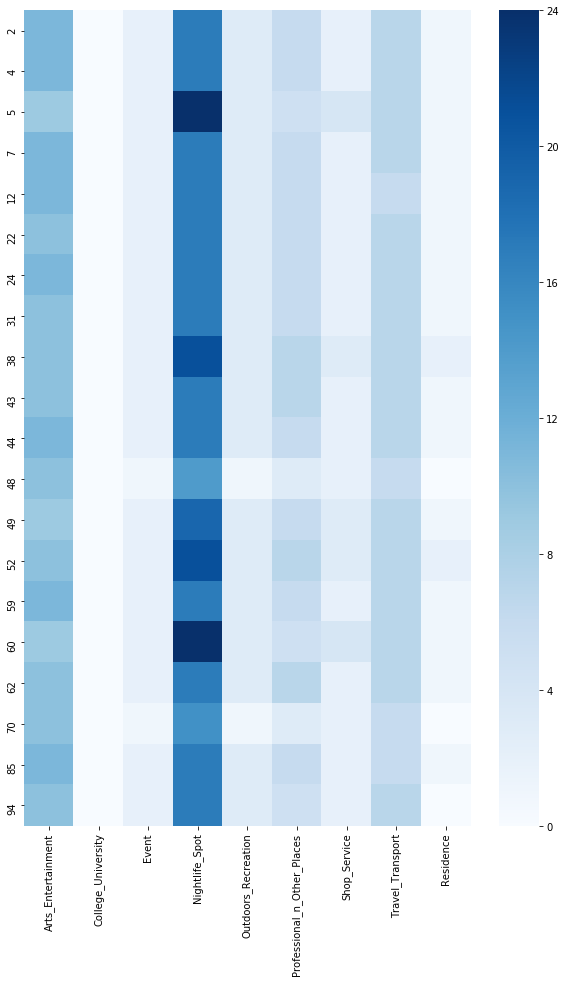

In [39]:
plt.figure(figsize= (10,15))
sns.heatmap(clusters[0].loc[:,'Arts_Entertainment':"Residence"],cmap = 'Blues')

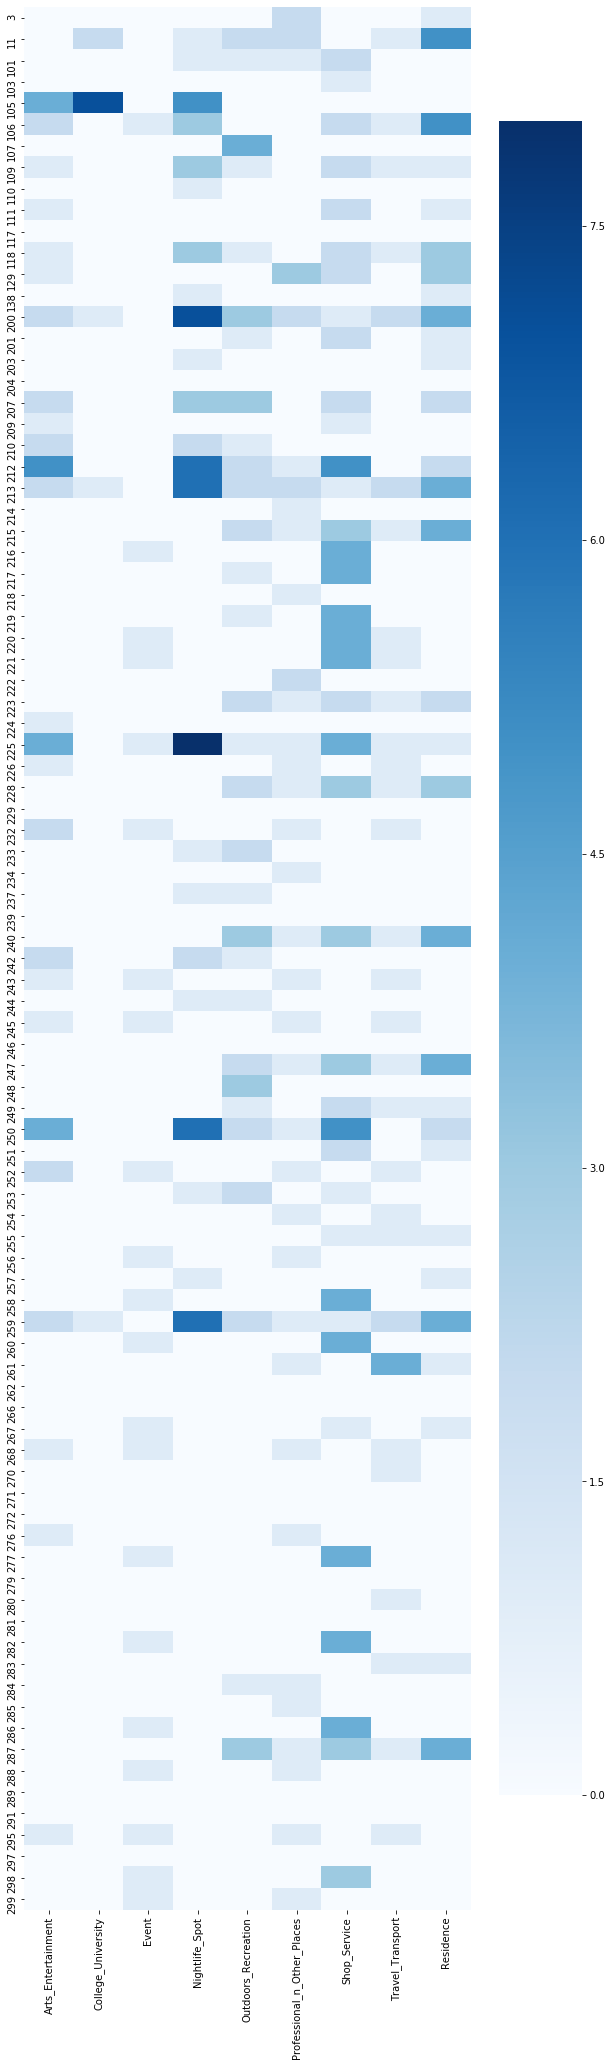

In [40]:
plt.figure(figsize= (10,35))
sns.heatmap(clusters[1].loc[:,'Arts_Entertainment':'Residence'],cmap = 'Blues')

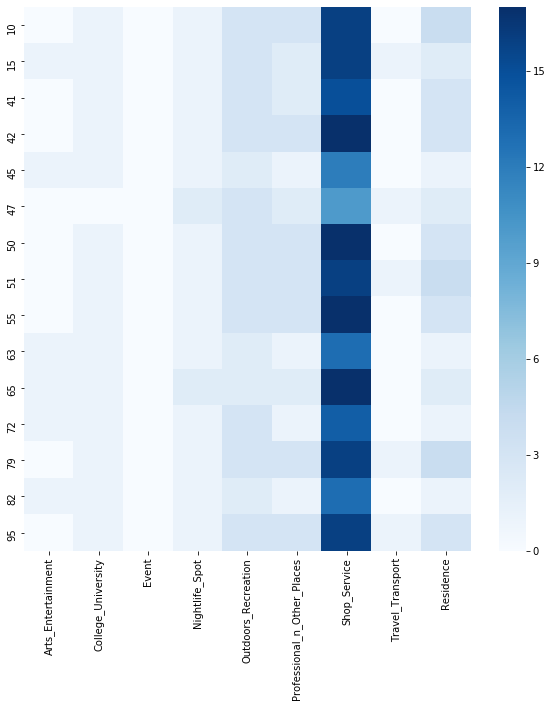

In [41]:
plt.figure(figsize= (10,10))
sns.heatmap(clusters[2].loc[:,'Arts_Entertainment':"Residence"],cmap = 'Blues')

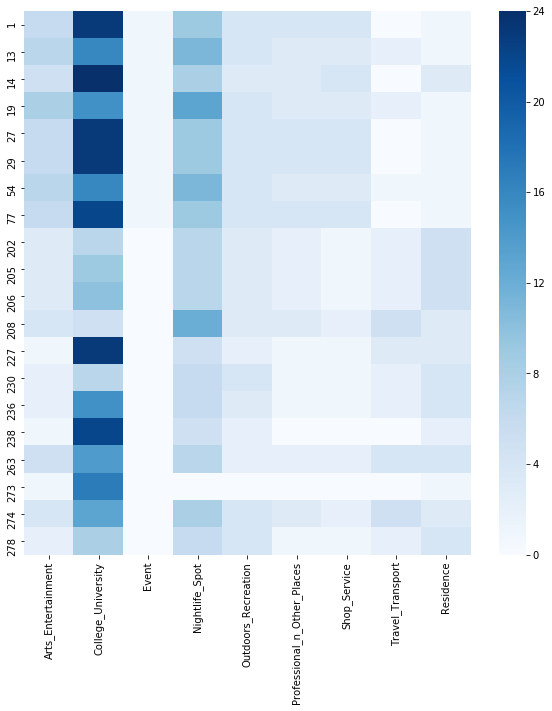

In [42]:
plt.figure(figsize= (10,10))
sns.heatmap(clusters[3].loc[:,'Arts_Entertainment':"Residence"],cmap = 'Blues')

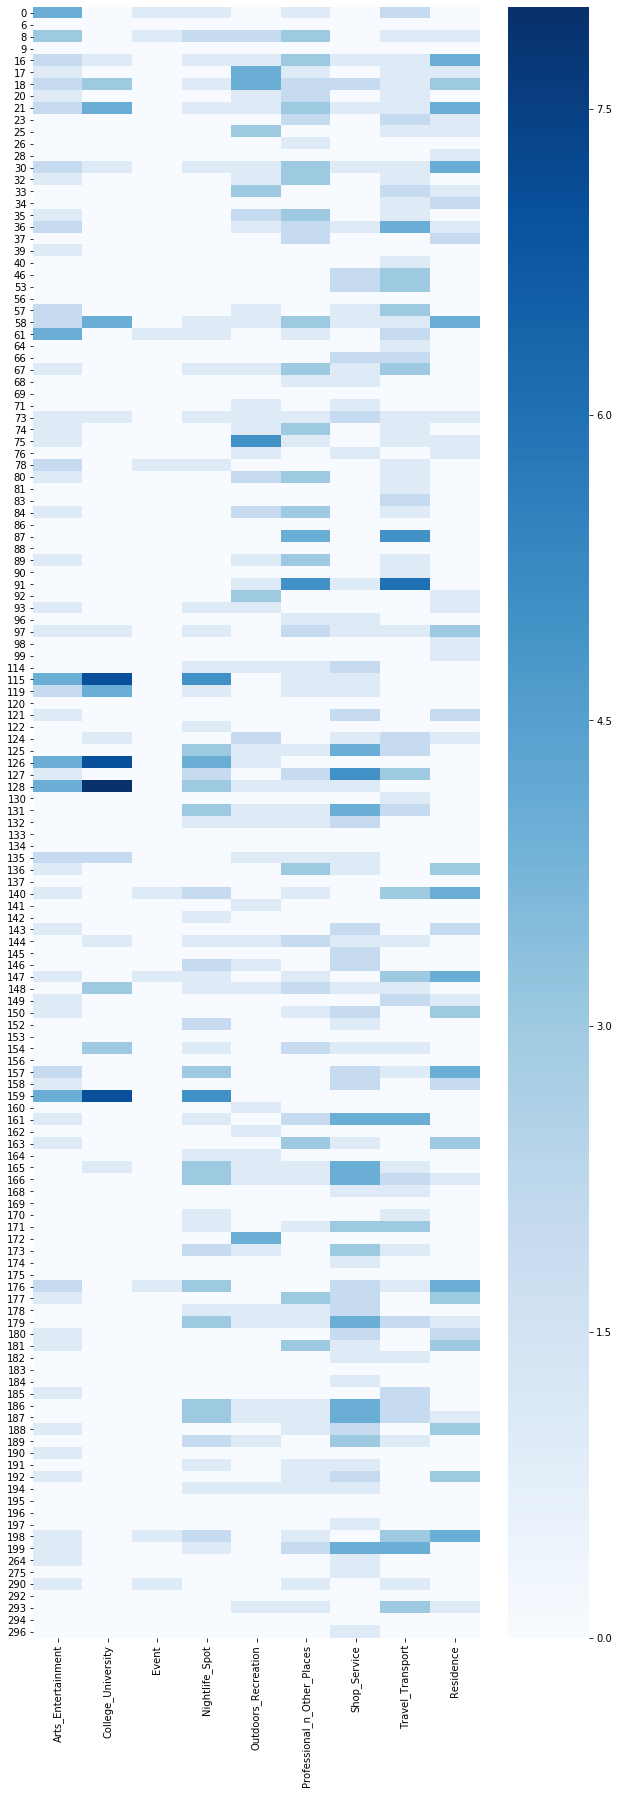

In [43]:
plt.figure(figsize= (10,30))
sns.heatmap(clusters[4].loc[:,'Arts_Entertainment':"Residence"],cmap = 'Blues')

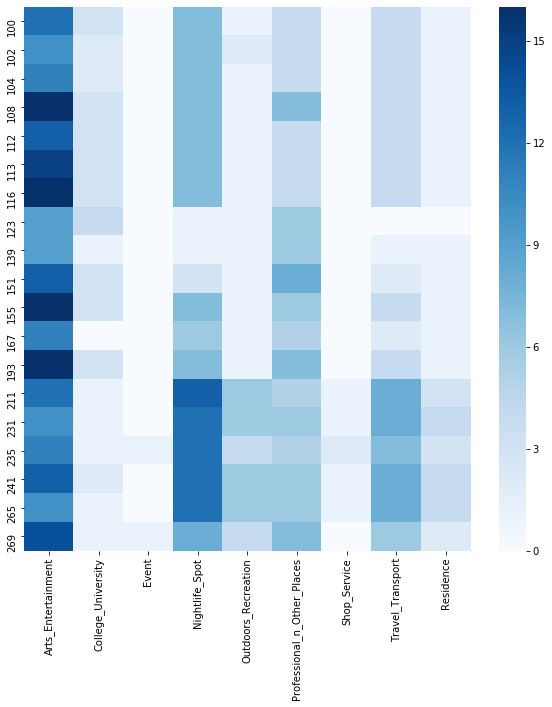

In [44]:
plt.figure(figsize= (10,10))
sns.heatmap(clusters[5].loc[:,'Arts_Entertainment':"Residence"],cmap = 'Blues')

### 4.3 Answer the question

From the Heatmaps we can see that, in cluster 0, cluster 3 and cluster 5, their restaurants have more venues around them than the other clusters, and it seems the cluster 5 is a better choice if we want to invest our money in to one of the restaurants, based on the location strategy, while cluster 0 is better than cluster 3, in terms of location strategy

Visualize all the restaurants and the venues

First, i'm going to concat every city venues datas in two one dataframe, and then i'm going to plot every venue using their coordinate, and beside that i'm also going to plot all the restaurants with their clusters

In [45]:
def venues_dataframe(dataframes):
    venues = pd.DataFrame()
    for i in dataframes.keys():
        venues = pd.concat([dataframes[i], venues], axis = 0)
    venues.reset_index(inplace=True, drop=True)
    return venues
d1 = venues_dataframe(Tuscaloosa_venues)
d2 = venues_dataframe(Montgomery_venues)
d3 = venues_dataframe(Brimingham_venues)
venues = pd.concat([d1,d2,d3], axis = 0).reset_index(drop=True)

In [46]:
venues.head()

,categories,id,location.formattedAddress,location.lat,location.lng,name,coordinate
0,Residential Building (Apartment / Condo),4c66de7919f3c9b6ff20a1ff,"1100 Hargrove Rd E, Tuscaloosa, AL 35405, Unit...",33.189918,-87.521484,Redpoint Tuscaloosa,"(33.18991839517019, -87.52148384698012)"
1,Residential Building (Apartment / Condo),4c0c04e57e3fc9282731f682,"grace street (University blvd.), Tuscaloosa, A...",33.212656,-87.554469,Preston place 2,"(33.21265578497721, -87.55446886038843)"
2,Residential Building (Apartment / Condo),4c5b243904f9be9ab78df360,"1900 Rice Mine Rd N, Tuscaloosa, AL 35406, Uni...",33.222982,-87.562209,High River Apartments,"(33.22298177790168, -87.56220913207223)"
3,Residential Building (Apartment / Condo),56468afd498ea0ff87ff9e60,"1418 10th Ave, Tuscaloosa, AL 35401, United St...",33.200005,-87.551736,Ion Tuscaloosa,"(33.20000484521273, -87.55173637349237)"
4,Residential Building (Apartment / Condo),4e0e3171d4c0f6d6b3f7b912,"1100 17th St (17th St), Tuscaloosa, AL 35401, ...",33.197602,-87.552679,Crimson Student Living,"(33.19760245537503, -87.5526792509311)"


In [49]:
venues.to_csv("venues.csv")

In [47]:
venu_labels = venues['categories'] + ', ' + venues['name'].astype(str)
for lat, lon, poi in zip(venues['location.lat'], venues['location.lng'], venu_labels):
    label = folium.Popup(poi, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='grey',
        fill=True,
        fill_color= 'grey',
        fill_opacity=0.7).add_to(map_clusters)

map_clusters

## 5. Discussion

For this project, k-means works properly. we use the most common venues in neighborhood, cluster the neighborhoods into 6 clusters. The result is good for our problem.

Although the result is accurate, we can also notice that the clusters is not precise enough. Adding more features like population and average income would be helpful.

## 6. Conclusion

1. Cluster 0 : just by looking at the stat desc and the heatmap, we can see that cluster 0 have more variety of venues around their restaurants and the number of the venues is high, so we can consider this as a good place to invest our money in one of their restaurants.
2. Cluster 1 : in cluster 1, the restaurants have higher rating with average over 4, have more reviews, and the price for two is more expencive than the other restaurants in other cluster, bur unfortunately the location strategy is not good because the number of venue around their restaurant is smaller then the other clusters.
3. Cluster 2 : in cluster 2, the price for two cheaper then the other clusters with average rating 3. Based on the heatmap, cluster 2 have variety of venues around their restaurants, and there are many shop-service around their restaurants
4. Cluster  3: From the Heatmaps we can see that, in cluster 3 their restaurants have more venues around them than the other clusters but not higher than cluster 5. and if we consider to invest our money in a restaurant that have more college students for their customers, the restaurants in cluster 3 is better place than in any other clusters.
5. Cluster 4 : From the Heatmaps, we can see that their restaurants have more variety venues around them, but the number of each venue is smaller than in other clusters bu not smaller than in cluster 1.
6. Cluster 5: The same as Cluster 0 and 3, in cluster 5 their restaurants have more variety venues around them, and the number of each venue is higher than any other clusters, espcecially their Arts and Entertainment venue. so, the cluster 5 is a better choice if we want to invest our money in to one of their restaurants, based on the location strategy,